# [데이콘 온라인 스터디] 3. 탐색적 데이터 분석(EDA) 심화

## 데이터를 더 압축해보자!

지난 6월부터 7월 중순까지 약 4주간에 걸쳐 원자력 상태판단대회 온라인 스터디(2기)가 진행되었습니다. 스터디에서 진행한 내용을 보다 많은 분들과 고민하고자 앞으로 4차례에 걸쳐 코드공유 게시물을 업로드할 예정입니다.

온라인 스터디와 관련한 자료는 아래 링크를 참조해 주세요.

- 데이콘 온라인 스터디 커리큘럼 [바로가기](https://www.dropbox.com/scl/fi/eaxxhf0pudm9jvckqgf4k/.papert?dl=0&rlkey=yqyrpk9eluqauoi5xjmywmp66)
- 1주차 세션 진행 자료 [바로가기](https://www.dropbox.com/scl/fi/hj22v4f47ythje8flvvm2/1.paper?dl=0&rlkey=0mrorfzb3hnvauscl459gl50z)
- 2주차 세션 진행 자료 [바로가기](https://www.dropbox.com/scl/fi/qezpyfkbj0om86afkk3bs/2.paper?dl=0&rlkey=i4nysx05x2tgy26mlkpu6cdhm)

------

세번째 주제는 <데이터를 더 압축해보자!>로, 차원분석을 통해 데이터의 경향성을 확인하고 이상치를 제거하여 데이터의 경제성을 높일 수 있는 방법에 대해 다뤄보고자 합니다.

이전 첫번째, 두번째 주제와 이어지는 게시물입니다.

- [데이콘 온라인 스터디] 1주차 - 칼럼을 2천개나 줄였습니다! 게시물 [바로가기](https://dacon.io/competitions/official/235551/codeshare/1371?page=1&dtype=recent&ptype=pub)
- [데이콘 온라인 스터디] 2주차 - 불균형한 데이터 분포, 어떻게 처리해야 할까? 게시물 [바로가기](https://dacon.io/competitions/official/235551/codeshare/1376?page=1&dtype=recent&ptype=pub)

*(이하 내용은 원자력 온라인 스터디 1, 2기에서 다루었던 내용이 포함되어 있습니다.)*

----


### 5. 차원축소

첫번째 게시글을 통해 칼럼을 약 2000여개를 drop 하였지만, 그럼에도 약 3000개의 칼럼이 남아 있습니다. 데이터의 경향성과 압축 가능성을 확인하기 위해 차원축소를 진행하였습니다.

우선 데이터를 로드하겠습니다. 방식은 이전 게시물과 동일합니다.

In [3]:
import multiprocessing 
from multiprocessing import Pool 
from functools import partial 
from data_loader_v2 import data_loader_v2
import os 
import pandas as pd
import numpy as np
import joblib

In [4]:
train_folder = 'train/'
train_list = os.listdir(train_folder)
train_label_path = 'train_label.csv'
train_label = pd.read_csv(train_label_path, index_col=0)

In [5]:
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=75):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)  
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close() 
        pool.join() 
    combined_df = pd.concat(df_list)
    return combined_df

In [6]:
# event_time=15, nrows=75 설정
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=15, nrows=75)

# 의미 없는 칼럼 드랍(첫번째 게시물 참조)
train = train.loc[:,train.std()!=0]

X_train = train.drop(['label'], axis=1)
y_train = train['label']

차원축소는 비지도 차원축소 방식인 PCA를 적용하였습니다.

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler = StandardScaler()
df_scaled=scaler.fit_transform(X_train)

# pca 차원축소
pca=PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

결과를 3차원 그래프로 시각화하여 확인해보겠습니다.

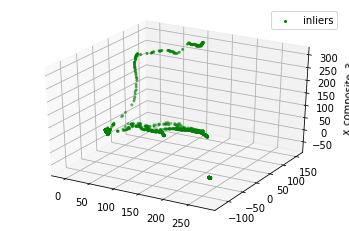

In [22]:
#시각화
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df_pca[:, 0], df_pca[:, 1], zs=df_pca[:, 2], s=4, lw=1, label="inliers",c="green")
ax.legend()
plt.show()

어느 정도의 경향성을 가지지만, 일부 이상치로 볼 수 있는 데이터도 존재하는 것 처럼 보입니다. 압축 가능성을 확인하기 위해 단순 rf모델로 성능 비교를 진행했습니다.

In [26]:
# 차원축소 성능평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf=RandomForestClassifier(n_estimators=300, random_state=156)
scores_pca = cross_val_score(rcf,df_pca, y_train, scoring='accuracy')

print('CV3인 경우 PCA변환된 개별 fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

CV3인 경우 PCA변환된 개별 fold 세트별 정확도 :  [0.05309855 0.10810811 0.13772864 0.13745564 0.13390663]
PCA 변환 데이터 세트 평균 정확도 : 0.1141




그러나 실제 rf 결과는 예상과 많이 달랐습니다. 평균 정확도 약 0.1141 정도로 상당히 성능이 저하된 것을 확인할 수 있습니다. 스케일링의 문제인가 싶어 standard 외 robust, minmax 등을 적용하여 비교하였으나, 성능에 큰 변화는 없었습니다.

따라서, 차원 축소를 적용하는 것은 적절하지 않다고 판단됩니다.

----

### 6. 이상치탐색

지금까지 칼럼 축소를 위주로 데이터 EDA를 진행하였는데, 이제 train 데이터셋의 row 데이터를 좀 더 살펴보겠습니다. 우리가 사용하고 있는 데이터 로드 모듈, data_loader_v2.py를 보면, 불러온 train 데이터의 row는 file id임을 알 수 있습니다.

따라서 row를 기준으로 이상치 탐색을 진행하면, 비교적 중요도가 낮은 file id를 제거할 수 있습니다. lsolation forest를 적용하여 이상치를 탐색을 진행했습니다. contamination변수를 0.01로 설정하여 전체 데이터 중 1%를 이상치로 간주하고 lf모델을 통해 이상치를 탐색한 결과입니다.

In [37]:
from sklearn.ensemble import IsolationForest
cif=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.01), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0,behaviour="new")
cif.fit(X_train)

pred = cif.predict(X_train)
X_train['out']=pred

C:\Users\jih02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


In [51]:
# 1이면 정상, -1이면 이상치 포함된 index
tmp=X_train.loc[X_train['out']==-1]
out_index=list(tmp.index)

In [43]:
# 이상치 row
tmp

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119,out
103,23.559128,4.274427,4.250021,3.751442,3.759234,-8.291305,34.442123,2.650298e+02,0.0,261.567632,...,110.859694,-0.300430,-0.234850,-0.148066,-0.148180,43.194587,0.1000,70.678227,8.82437,-1
103,23.544267,4.354535,4.258811,3.740691,3.782363,2.535554,6.121905,2.650298e+02,0.0,261.565717,...,110.921065,-0.301900,-0.229540,-0.225293,-0.141646,43.199915,0.1000,70.678226,8.82437,-1
103,23.538900,4.288717,4.233603,3.788568,3.805828,2.925952,-7.025525,2.650298e+02,0.0,261.564724,...,110.941848,-0.303200,-0.257178,-0.270651,-0.188651,43.197637,0.1000,70.678220,8.82437,-1
103,23.561275,4.308862,4.239103,3.765229,3.797751,13.439356,-27.703969,2.650298e+02,0.0,261.568362,...,110.876239,-0.292275,-0.222797,-0.185541,-0.161072,43.191146,0.1000,70.678230,8.82437,-1
103,23.546555,4.228655,4.257381,3.758402,3.783031,-15.119784,-10.500483,2.650298e+02,0.0,261.567716,...,110.877679,-0.288895,-0.245284,-0.236787,-0.170444,43.205434,0.1000,70.678220,8.82437,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,24.044489,4.286894,4.213520,3.786237,3.782339,-1.313453,-21.468657,2.651105e+02,0.0,261.569403,...,110.912965,-0.272413,-0.246441,-0.198147,-0.145400,43.193136,0.1000,70.678221,8.82437,-1
176,24.059724,4.353295,4.240205,3.774026,3.795141,8.448634,-20.689173,2.651098e+02,0.0,261.569243,...,110.848742,-0.293415,-0.233067,-0.183883,-0.140670,43.203261,0.1000,70.678225,8.82437,-1
176,24.046723,4.269111,4.266959,3.749095,3.772972,8.307168,-17.935429,2.651105e+02,0.0,261.570471,...,110.971647,-0.307250,-0.241933,-0.174509,-0.140263,43.189406,0.1000,70.678208,8.82437,-1
176,24.054898,4.275377,4.252281,3.760244,3.782365,19.138578,-37.828581,2.651105e+02,0.0,261.569444,...,110.931214,-0.282216,-0.227733,-0.212222,-0.163397,43.196402,0.1000,70.678223,8.82437,-1


총 367개의 칼럼이 탐색되었습니다. 중복값을 제거하지 않은 out_index를 보면 이상치로 판단된 file id는 대부분 103, 176 위주로, 해당 file id만을 drop하기로 결정했습니다. 결과는 다음과 같습니다.

In [52]:
print(out_index)

[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,

In [53]:
# id 103, 176만 삭제
out_index.remove(290)
X_train = X_train.drop(['out'], axis=1)

X_train = X_train.drop(out_index)
y_train = y_train.drop(out_index)

In [60]:
X_train.shape, y_train.shape

((36260, 3455), (36260,))

In [61]:
# 제거한 row
X_train

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5084,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119
0,30.469574,8.722739,8.686953,8.677701,8.696935,215.779134,148.857105,-8.951266e-20,0.0,-0.000694,...,110.922023,110.958197,-0.298096,-0.234462,-0.241420,-0.164439,43.197957,60.0,-2.988467e-06,85.4
0,30.471422,8.843733,8.724614,8.736648,8.724141,189.935527,186.819255,5.018471e-19,0.0,0.001233,...,110.918918,110.930774,-0.311288,-0.229316,-0.230339,-0.174198,43.194910,60.0,1.136327e-05,85.4
0,30.465795,8.639923,8.693430,8.706842,8.698667,167.172015,227.642581,5.601811e-19,0.0,0.000029,...,110.923194,110.877289,-0.275290,-0.247143,-0.175712,-0.179520,43.206854,60.0,1.157871e-06,85.4
0,30.451257,8.643156,8.721100,8.677412,8.697360,190.645984,181.005102,4.328276e-19,0.0,-0.001779,...,110.822725,110.848307,-0.286780,-0.240937,-0.212229,-0.157415,43.198779,60.0,4.229167e-06,85.4
0,30.469449,8.786702,8.718487,8.632532,8.686938,208.447021,202.666961,3.835715e-19,0.0,-0.000019,...,110.810634,110.926518,-0.301789,-0.237373,-0.201726,-0.188566,43.204087,60.0,1.503048e-06,85.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,30.466798,8.781396,8.656021,8.741145,8.678219,183.032479,198.732448,5.160292e-19,0.0,-0.002553,...,110.878279,110.853071,-0.292044,-0.230561,-0.188257,-0.138816,43.196687,60.0,4.202532e-07,85.4
822,30.487399,8.813155,8.718072,8.723063,8.724389,209.083991,153.851021,-6.571058e-19,0.0,0.000800,...,110.852287,110.798022,-0.281708,-0.233645,-0.252706,-0.165436,43.201587,60.0,3.512496e-07,85.4
822,30.467739,8.752970,8.674999,8.683145,8.694938,194.415606,250.116154,4.640560e-20,0.0,-0.001554,...,111.049257,110.944531,-0.293674,-0.216244,-0.205386,-0.175538,43.207345,60.0,-6.612851e-06,85.4
822,30.451295,8.725999,8.702534,8.673263,8.707673,216.079464,197.389922,-1.351444e-19,0.0,-0.000090,...,111.054845,111.045120,-0.287287,-0.242544,-0.238269,-0.135583,43.199317,60.0,-3.596244e-05,85.4


이상치 제거 결과의 성능 평가를 위해 단순 rf 모델을 사용하여 원본 데이터 결과와 비교해보았습니다. 원본 데이터의 rf 정확도 점수는 첫번째 게시물 또는 아래 결과 화면 사진을 참고해주세요.

![rf결과](https://ifh.cc/g/TkWnpw.jpg)

In [63]:
#file id제거 성능평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf=RandomForestClassifier(n_estimators=300)
scores = cross_val_score(rcf, X_train, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.76302639 0.84346819 0.85268906]
평균 정확도 : 0.8197


결과는 약 정확도 0.82정도로 약간의 성능 개선 효과를 볼 수 있었습니다.

덧붙이자면 file id 103은 라벨 54에 속하고, file id 176은 라벨 53에 속합니다. 또한 라벨 54는 12개, 53은 7개의 file이 속합니다. 최대값 24(라벨 110)에 비하면 적은 수치이기에 적은 file이 할당된 라벨의 file을 제거하는 것이 적절한지 많은 고민을 하게 되었습니다.

lf모델의 contamination변수를 0.002~0.01로 변화를 주어도 결과는 동일하였습니다. 여러 lf 모델을 통해 동일한 결과가 이상치로 판단되었다는 점에서 해당 id를 제거하는 방향으로 결정하였고, 위 결과처럼 단순 rf모델로 성능 개선 효과를 확인할 수 있었습니다.

지금까지 데이터 전처리에 대해 살펴보았습니다. 다음 게시물에서는 모델링을 다루겠습니다.

